# 1. MAE Model

In [1]:
# Step 1: Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from visionts import VisionTS
from visionts.models_mae import MaskedAutoencoderViT
from torchvision.transforms import ToTensor
from PIL import Image
import os
from timm.models.vision_transformer import PatchEmbed, Block
from sklearn.metrics import mean_squared_error, mean_absolute_error


d:\OneDrive - Dialog Axiata PLC\STUDIES\MSC\Sem 3\PG Dip Project CS5999\VisionTS-main\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# STEP 0: Configurable forecast length
PRED_LEN = 100  # 👈 CHANGE THIS ONLY


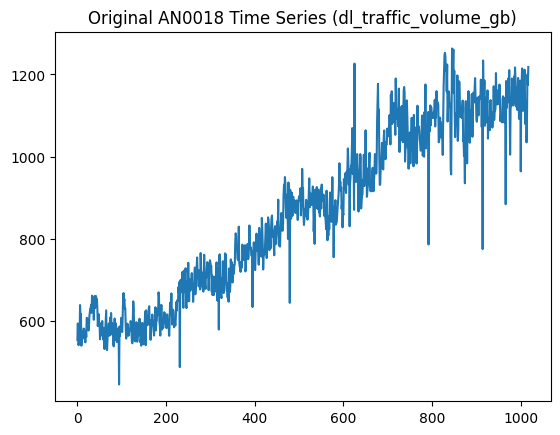

In [9]:
# Step 2: Load a short AN0018 sequence from CSV (uni + bi)

df = pd.read_csv('./long_term_tsf/dataset/ETT-small/AN0018.csv')

CONTEXT_LEN = len(df) - PRED_LEN

# Main target series (for baseline MAE + evaluation)
traffic = df['dl_traffic_volume_gb'].values.astype(np.float32)[:CONTEXT_LEN + PRED_LEN]

# Second series (bivariate context)
connected = df['connected_users'].values.astype(np.float32)[:CONTEXT_LEN + PRED_LEN]

# Univariate series used by the original MAE demo (Section 1)
data = traffic

# Bivariate series [T, 2] used by BiViSIONTS (Section 2)
bi_data = np.stack([traffic, connected], axis=-1)  # shape [T, 2]

plt.plot(data)
plt.title("Original AN0018 Time Series (dl_traffic_volume_gb)")
plt.show()


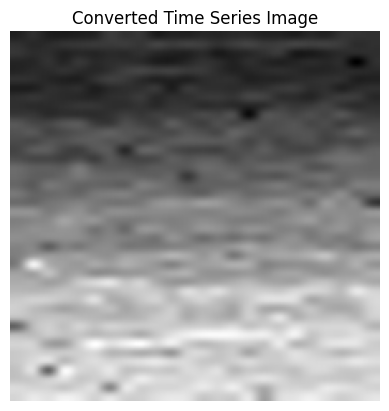

In [10]:
# Step 3: Convert time series to image
def series_to_image(series, context_len, pred_len, periodicity=24):
    total_len = context_len + pred_len
    # truncate to make divisible by periodicity
    usable_len = total_len - (total_len % periodicity)
    matrix = series[:usable_len].reshape(-1, periodicity)
    matrix = (matrix - matrix.min()) / (matrix.max() - matrix.min())
    image = (matrix * 255).astype(np.uint8)
    img = Image.fromarray(image).convert("L").resize((224, 224))
    return img.convert("RGB"), usable_len

img, usable_len = series_to_image(data, CONTEXT_LEN, PRED_LEN)
plt.imshow(img)
plt.title("Converted Time Series Image")
plt.axis('off')
plt.show()

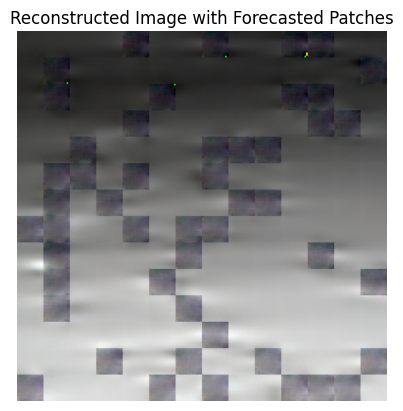

In [5]:
# Step 4: Run MAE reconstruction (simulate zero-shot forecast)
model = MaskedAutoencoderViT(
    img_size=224, patch_size=16, in_chans=3,
    embed_dim=768, depth=12, num_heads=12,
    decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16
)

ckpt_path = './ckpt/mae_visualize_vit_base.pth'
ckpt = torch.load(ckpt_path, map_location='cpu')
model.load_state_dict(ckpt['model'], strict=False)
model.eval()

x = ToTensor()(img).unsqueeze(0)
with torch.no_grad():
    latent, mask, ids_restore = model.forward_encoder(x, mask_ratio=0.75)
    pred = model.forward_decoder(latent, ids_restore)
    output = model.unpatchify(pred).squeeze().permute(1, 2, 0).numpy()

output = (output * 255).astype(np.uint8)
reconstructed_img = Image.fromarray(output)
plt.imshow(reconstructed_img)
plt.title("Reconstructed Image with Forecasted Patches")
plt.axis('off')
plt.show()

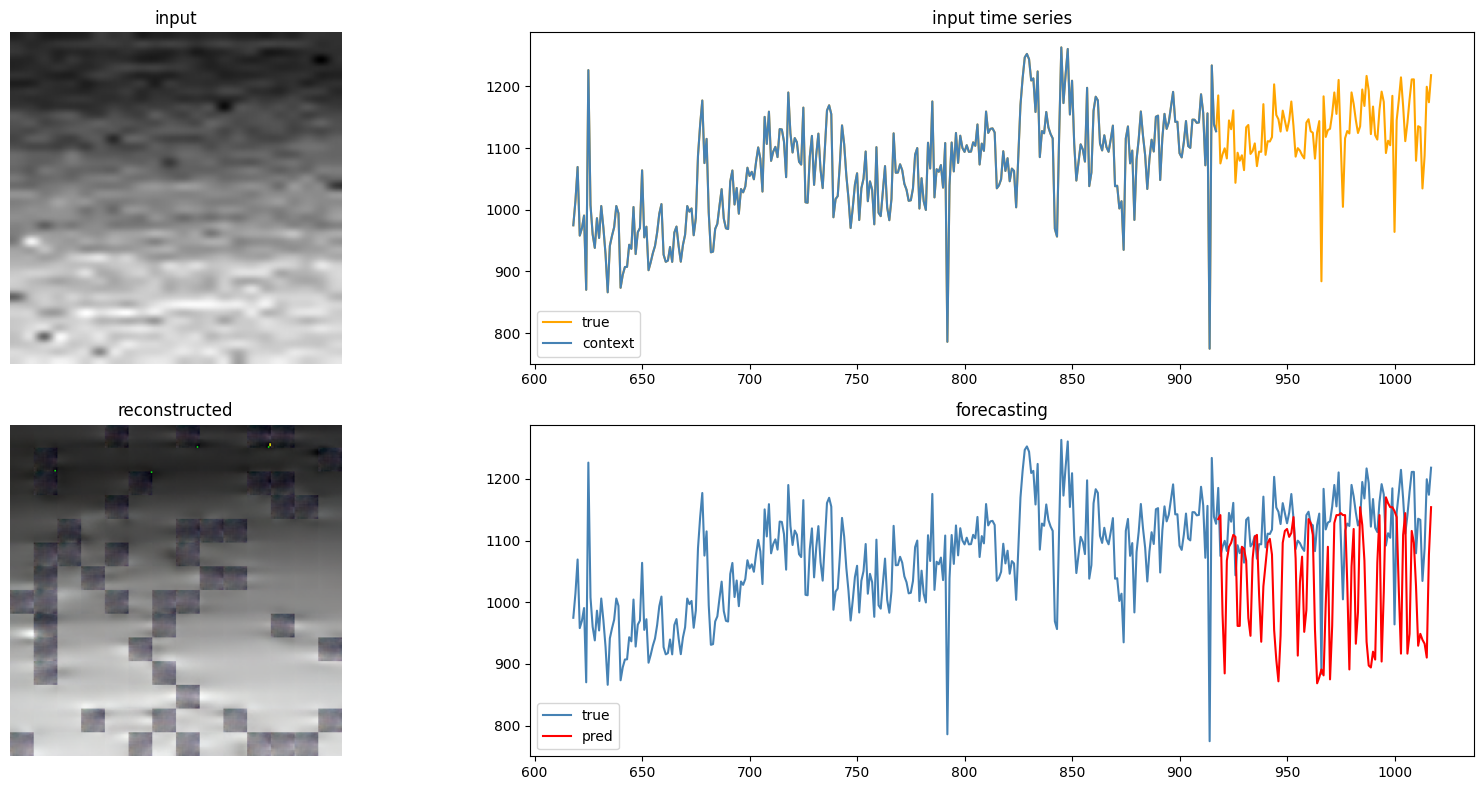

📊 Forecast Evaluation Metrics:
  MSE  = 20345.0682
  MAE  = 111.1415
  RMSE = 142.6361
✅ Success Rate (±10% tolerance): 57.00%


In [7]:
PLOT_CONTEXT_LEN = 300  # 👈 Only change this to zoom in or out

# Convert reconstructed image back to time series
periodicity = 24
matrix_h = (CONTEXT_LEN + PRED_LEN) // periodicity
recon_gray = reconstructed_img.convert("L").resize((periodicity, matrix_h), Image.BILINEAR)
recon_array = np.array(recon_gray).astype(np.float32) / 255.0
reconstructed_series = recon_array.flatten()
forecast_series = reconstructed_series[-PRED_LEN:]

# Denormalize forecast
data_min = data.min()
data_max = data.max()
forecast_denorm = forecast_series * (data_max - data_min) + data_min
full_series = data[:CONTEXT_LEN + PRED_LEN]

# Build predicted sequence
pred_series = np.concatenate([full_series[:CONTEXT_LEN], forecast_denorm])

# --- Plot combined layout like VISIONTS paper ---
fig, axs = plt.subplots(2, 2, figsize=(18, 8))

axs[0, 0].imshow(img)
axs[0, 0].set_title("input")
axs[0, 0].axis("off")

axs[1, 0].imshow(reconstructed_img)
axs[1, 0].set_title("reconstructed")
axs[1, 0].axis("off")

# Plot a zoomed-in portion of the context
axs[0, 1].plot(
    np.arange(CONTEXT_LEN - PLOT_CONTEXT_LEN, CONTEXT_LEN + PRED_LEN),
    full_series[CONTEXT_LEN - PLOT_CONTEXT_LEN: CONTEXT_LEN + PRED_LEN],
    label="true", color="orange"
)
axs[0, 1].plot(
    np.arange(CONTEXT_LEN - PLOT_CONTEXT_LEN, CONTEXT_LEN),
    full_series[CONTEXT_LEN - PLOT_CONTEXT_LEN: CONTEXT_LEN],
    label="context", color="steelblue"
)
axs[0, 1].set_title("input time series")
axs[0, 1].legend()

# Forecasting plot
axs[1, 1].plot(
    np.arange(CONTEXT_LEN - PLOT_CONTEXT_LEN, CONTEXT_LEN + PRED_LEN),
    full_series[CONTEXT_LEN - PLOT_CONTEXT_LEN: CONTEXT_LEN + PRED_LEN],
    label="true", color="steelblue"
)
axs[1, 1].plot(
    np.arange(CONTEXT_LEN, CONTEXT_LEN + PRED_LEN),
    forecast_denorm, label="pred", color="red"
)
axs[1, 1].set_title("forecasting")
axs[1, 1].legend()

plt.tight_layout()
plt.show()


# Get ground truth for forecast window
true_forecast = full_series[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]

# --- 1. Error Metrics ---
mse = mean_squared_error(true_forecast, forecast_denorm)
mae = mean_absolute_error(true_forecast, forecast_denorm)
rmse = np.sqrt(mse)

# --- 2. Success Rate ---
# Define success as prediction within ±10% of true value
tolerance = 0.10
success_mask = np.abs(forecast_denorm - true_forecast) <= tolerance * np.abs(true_forecast)
success_rate = success_mask.sum() / len(true_forecast)

# --- Print results ---
print(f"📊 Forecast Evaluation Metrics:")
print(f"  MSE  = {mse:.4f}")
print(f"  MAE  = {mae:.4f}")
print(f"  RMSE = {rmse:.4f}")
print(f"✅ Success Rate (±10% tolerance): {success_rate * 100:.2f}%")


# 2. VisionTS Model

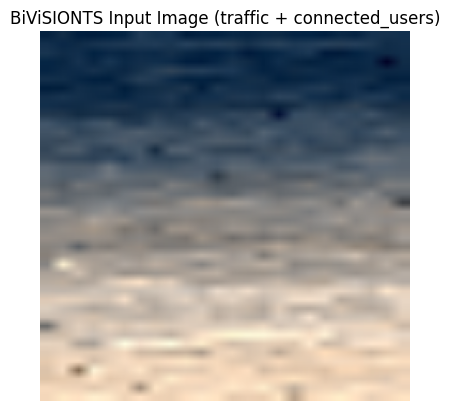

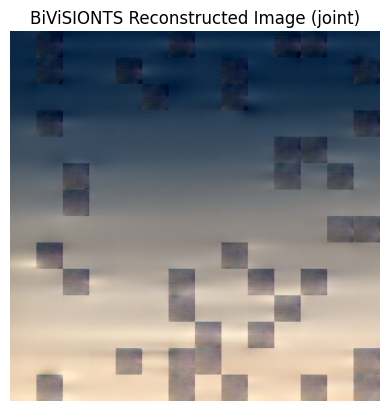

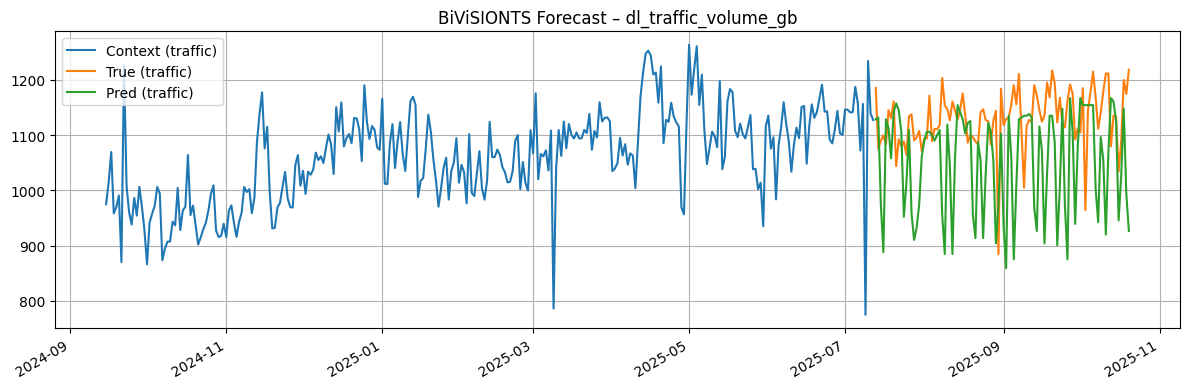

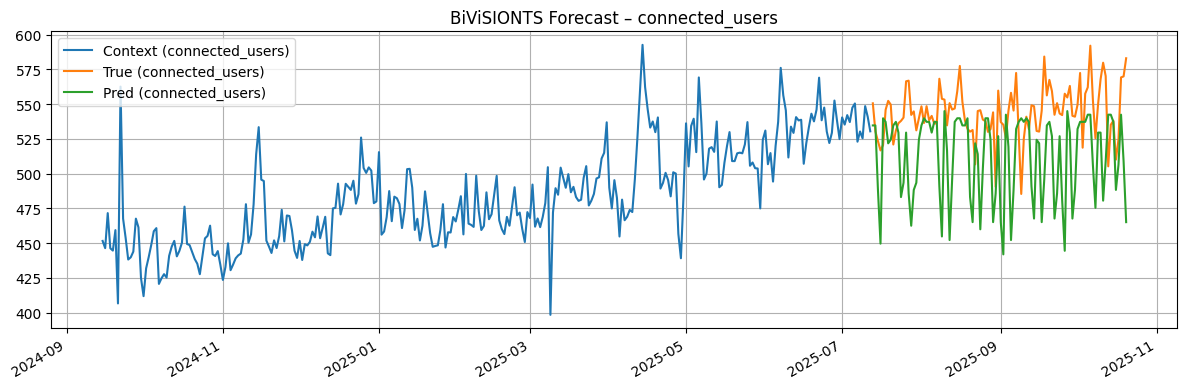

📊 BiViSIONTS Forecast Evaluation (traffic only):
  MSE  = 17049.3418
  MAE  = 99.0689
  RMSE = 130.5731
✅ Success Rate (±10% tolerance): 62.00%


In [19]:
# 2. BiViSIONTS Model – joint RGB encoding of (traffic, connected_users)

PLOT_CONTEXT_LEN = 300
periodicity = 24          # hours per day (or other natural period)
alpha = 0.3               # how strongly connected_users perturbs color

# --- Load AN0018 and build full sequences ---
df = pd.read_csv('./long_term_tsf/dataset/ETT-small/AN0018.csv')
timestamps = pd.to_datetime(df['date'].values)

traffic = df['dl_traffic_volume_gb'].values.astype(np.float32)
connected = df['connected_users'].values.astype(np.float32)

CONTEXT_LEN = len(df) - PRED_LEN

traffic_full = traffic[:CONTEXT_LEN + PRED_LEN]
connected_full = connected[:CONTEXT_LEN + PRED_LEN]


# --- BiV encoding: two series -> one RGB image (gray + color) ---

def bivariate_to_image(series1, series2, context_len, pred_len,
                       periodicity=24, alpha=0.3):
    """
    series1 -> gray (all RGB channels share it)
    series2 -> color perturbation (R up, B down when series2 is high)

    Returns:
        img (PIL.Image RGB, 224x224)
        meta (dict) with scaling info for inverse mapping
    """
    total_len = context_len + pred_len
    usable_len = total_len - (total_len % periodicity)

    s1 = series1[:usable_len]
    s2 = series2[:usable_len]

    s1_min, s1_max = float(s1.min()), float(s1.max())
    s2_min, s2_max = float(s2.min()), float(s2.max())

    s1_norm = (s1 - s1_min) / (s1_max - s1_min + 1e-8)
    s2_norm = (s2 - s2_min) / (s2_max - s2_min + 1e-8)

    h = usable_len // periodicity
    s1_mat = s1_norm.reshape(h, periodicity)
    s2_mat = s2_norm.reshape(h, periodicity)

    gray = s1_mat                       # base intensity from traffic
    delta = s2_mat - 0.5                # center around 0

    # gray + color encoding
    R = np.clip(gray + alpha * delta, 0.0, 1.0)
    G = gray
    B = np.clip(gray - alpha * delta, 0.0, 1.0)

    rgb = np.stack([R, G, B], axis=-1)  # [H, W, 3]
    img = Image.fromarray((rgb * 255).astype(np.uint8)).resize(
        (224, 224), Image.BILINEAR
    )

    meta = {
        "usable_len": usable_len,
        "s1_min": s1_min,
        "s1_max": s1_max,
        "s2_min": s2_min,
        "s2_max": s2_max,
        "periodicity": periodicity,
        "alpha": alpha,
    }
    return img, meta


def image_to_bivariate(img, meta):
    """
    Inverse of bivariate_to_image.
    Reconstructs 2 time series from a *single* RGB image.
    """
    periodicity = meta["periodicity"]
    usable_len = meta["usable_len"]
    alpha = meta["alpha"]
    h = usable_len // periodicity

    recon_rgb = img.resize((periodicity, h), Image.BILINEAR)
    recon_array = np.array(recon_rgb).astype(np.float32) / 255.0

    R = recon_array[..., 0]
    G = recon_array[..., 1]
    B = recon_array[..., 2]

    gray_rec = np.clip(G, 0.0, 1.0)
    delta_rec = np.clip((R - B) / (2.0 * alpha + 1e-8), -0.5, 0.5)

    s1_norm_rec = gray_rec
    s2_norm_rec = np.clip(delta_rec + 0.5, 0.0, 1.0)

    s1_rec = s1_norm_rec.flatten() * (meta["s1_max"] - meta["s1_min"]) + meta["s1_min"]
    s2_rec = s2_norm_rec.flatten() * (meta["s2_max"] - meta["s2_min"]) + meta["s2_min"]

    return s1_rec, s2_rec


# --- Build BiViSIONTS input image ---

biv_img, meta = bivariate_to_image(
    traffic_full, connected_full,
    CONTEXT_LEN, PRED_LEN,
    periodicity=periodicity,
    alpha=alpha,
)

plt.imshow(biv_img)
plt.title("BiViSIONTS Input Image (traffic + connected_users)")
plt.axis('off')
plt.show()


# --- MAE backbone (same as in Section 1 / VisionTS) ---

bivision_model = MaskedAutoencoderViT(
    img_size=224, patch_size=16, in_chans=3,
    embed_dim=768, depth=12, num_heads=12,
    decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16
)

ckpt_path = './ckpt/mae_visualize_vit_base.pth'
ckpt = torch.load(ckpt_path, map_location='cpu')
bivision_model.load_state_dict(ckpt['model'], strict=False)
bivision_model.eval()

x_img = ToTensor()(biv_img).unsqueeze(0)

with torch.no_grad():
    latent, mask, ids_restore = bivision_model.forward_encoder(x_img, mask_ratio=0.80)
    pred = bivision_model.forward_decoder(latent, ids_restore)
    output = bivision_model.unpatchify(pred).squeeze().permute(1, 2, 0).numpy()

output = np.clip(output, 0.0, 1.0)
reconstructed_biv_img = Image.fromarray((output * 255).astype(np.uint8))

plt.imshow(reconstructed_biv_img)
plt.title("BiViSIONTS Reconstructed Image (joint)")
plt.axis('off')
plt.show()


# --- Decode back to two series, take forecast part ---

rec_traffic, rec_connected = image_to_bivariate(reconstructed_biv_img, meta)

# last PRED_LEN points are the forecast window
traffic_forecast = rec_traffic[-PRED_LEN:]
connected_forecast = rec_connected[-PRED_LEN:]

true_traffic = traffic_full[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]
true_connected = connected_full[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]

time_x = timestamps[:CONTEXT_LEN]
time_y = timestamps[CONTEXT_LEN:CONTEXT_LEN + PRED_LEN]


# --- Plots: traffic ---

plt.figure(figsize=(12, 4))
plt.plot(time_x[-PLOT_CONTEXT_LEN:],
         traffic_full[:CONTEXT_LEN][-PLOT_CONTEXT_LEN:],
         label="Context (traffic)")
plt.plot(time_y, true_traffic, label="True (traffic)")
plt.plot(time_y, traffic_forecast, label="Pred (traffic)")
plt.gcf().autofmt_xdate()
plt.title("BiViSIONTS Forecast – dl_traffic_volume_gb")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# --- Plots: connected_users ---

plt.figure(figsize=(12, 4))
plt.plot(time_x[-PLOT_CONTEXT_LEN:],
         connected_full[:CONTEXT_LEN][-PLOT_CONTEXT_LEN:],
         label="Context (connected_users)")
plt.plot(time_y, true_connected, label="True (connected_users)")
plt.plot(time_y, connected_forecast, label="Pred (connected_users)")
plt.gcf().autofmt_xdate()
plt.title("BiViSIONTS Forecast – connected_users")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# --- Evaluation on traffic (primary target) ---

true_vals = true_traffic
pred_vals = traffic_forecast

mse = mean_squared_error(true_vals, pred_vals)
mae = mean_absolute_error(true_vals, pred_vals)
rmse = np.sqrt(mse)

tolerance = 0.10
success_mask = np.abs(pred_vals - true_vals) <= tolerance * np.abs(true_vals)
success_rate = success_mask.sum() / len(true_vals)

print("📊 BiViSIONTS Forecast Evaluation (traffic only):")
print(f"  MSE  = {mse:.4f}")
print(f"  MAE  = {mae:.4f}")
print(f"  RMSE = {rmse:.4f}")
print(f"✅ Success Rate (±10% tolerance): {success_rate * 100:.2f}%")
